In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm.notebook import trange, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc , roc_auc_score , confusion_matrix
from IPython.display import clear_output


In [2]:
PATH = "/home/advice/Python/SR/Data/Rain/weatherAUS.csv"
data = pd.read_csv(PATH)

In [3]:
data.shape

(142193, 24)

In [4]:
notuse = ["RISK_MM", "Date"]
d = data[notuse]

In [5]:
data = data.drop(notuse , axis = 1)

In [6]:
data.shape

(142193, 22)

In [7]:
target = data.pop("RainTomorrow")

In [8]:
target.head()

0    No
1    No
2    No
3    No
4    No
Name: RainTomorrow, dtype: object

In [9]:
objcol = data.select_dtypes("object").columns.tolist()

In [10]:
numcol = data.select_dtypes("float").columns.tolist()

In [11]:
ModelCol = numcol + objcol
total_dim = len(ModelCol)
data = data[ModelCol]

In [12]:
totalcol = data.columns.tolist()
objinfo = [idx for idx , col in enumerate(totalcol) if col in objcol ]

In [13]:
target = LabelEncoder().fit_transform(target)

In [14]:
train_X , test_X , train_Y , test_Y =\
train_test_split(data, target , test_size = 0.3 , stratify = target )

In [15]:
train_X.shape , train_Y.shape

((99535, 21), (99535,))

In [16]:
target

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
test_X.shape , test_Y.shape

((42658, 21), (42658,))

In [18]:
train_X.head() , train_Y

(       MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
 67140     13.2     20.0       NaN          4.8       7.7           80.0   
 95320     11.7     27.2       0.0          NaN       NaN           46.0   
 78659     18.1     28.7       0.6          4.8       5.1           20.0   
 5294       9.5     20.6       0.2          NaN       NaN           43.0   
 88964     22.1     28.2       3.2          NaN       NaN           48.0   
 
        WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  Pressure3pm  \
 67140          20.0          37.0         73.0         28.0  ...       1007.6   
 95320          22.0          22.0         32.0         21.0  ...       1007.6   
 78659           4.0           7.0         86.0         57.0  ...       1012.0   
 5294            2.0           9.0        100.0         52.0  ...          NaN   
 88964          31.0          31.0         78.0         74.0  ...       1007.2   
 
        Cloud9am  Cloud3pm  Temp9am  Temp3pm    

In [19]:
len(set(train_X["Location"].unique()) & set(test_X["Location"].unique()))

49

In [20]:
len(set(train_X["Location"].unique()) )

49

In [21]:
LabelEncoding = {}
for col in objcol :
    print(col)
    encoding = LabelEncoder()
    category = list(set(list(train_X[col].unique()) + [np.nan]))
    encoding.fit(category)
    train_X[col] = train_X[col].fillna('nan')
    train_X[col] = encoding.transform(train_X[col])
    LabelEncoding[col] = encoding

Location
WindGustDir
WindDir9am
WindDir3pm
RainToday


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 변형셋 모으기 

In [22]:
from time import time
start = time()
change = {}
for col in objcol :
    change[col] = {}
    LABLEncoder = LabelEncoding[col]
    unknownlabel = set(test_X[col].unique()).difference(set(LABLEncoder.classes_))
    c = dict(zip(unknownlabel , [np.nan] * len(unknownlabel)))
    c[np.nan] = 'nan'
    change[col] = c
    
print("{}초".format(time()- start))

0.013705730438232422초


In [23]:
for col in objcol :
    print(col)
    LABLEncoder = LabelEncoding[col]
    unknownlabel = set(test_X[col].unique()).difference(set(LABLEncoder.classes_))
    c = dict(zip(unknownlabel , [np.nan] * len(unknownlabel)))
    c[np.nan] = 'nan'
    test_X[col] = test_X[col].replace(c)   
    test_X[col] = LABLEncoder.transform(test_X[col])

Location


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


WindGustDir
WindDir9am
WindDir3pm
RainToday


/root/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
train_X = train_X.astype(np.float32)
test_X = test_X.astype(np.float32)

from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(train_X[numcol])
train_X[numcol] = imp_mean.transform(train_X[numcol])
test_X[numcol] = imp_mean.transform(test_X[numcol])

In [25]:
train_X.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday
67140,13.2,20.000000,2.360221,4.800000,7.700000,80.0,20.0,37.0,73.0,28.0,...,1007.599976,4.43033,4.502426,13.300000,18.200001,18.0,3.0,15.0,13.0,2.0
95320,11.7,27.200001,0.000000,5.464595,7.643549,46.0,22.0,22.0,32.0,21.0,...,1007.599976,4.43033,4.502426,20.700001,24.100000,0.0,7.0,4.0,3.0,0.0
78659,18.1,28.700001,0.600000,4.800000,5.100000,20.0,4.0,7.0,86.0,57.0,...,1012.000000,8.00000,5.000000,19.700001,26.600000,44.0,15.0,11.0,12.0,0.0
5294,9.5,20.600000,0.200000,5.464595,7.643549,43.0,2.0,9.0,100.0,52.0,...,1015.275269,4.43033,4.502426,12.400000,20.400000,4.0,14.0,5.0,7.0,0.0
88964,22.1,28.200001,3.200000,5.464595,7.643549,48.0,31.0,31.0,78.0,74.0,...,1007.200012,4.43033,4.502426,25.700001,26.500000,14.0,5.0,4.0,5.0,1.0


In [26]:
objdict = {}
for i in objinfo :
    objdict[i] = train_X.iloc[:, i].nunique()
objdict

{16: 49, 17: 17, 18: 17, 19: 17, 20: 3}

In [27]:
tf.reset_default_graph()
batch_size = tf.placeholder(tf.int64, name="Batchsize")
X =  tf.placeholder(tf.float32 , shape = [None , total_dim])
y = tf.placeholder(tf.float32 , [None])
#y = tf.string_to_number(y)
X , y 

(<tf.Tensor 'Placeholder:0' shape=(?, 21) dtype=float32>,
 <tf.Tensor 'Placeholder_1:0' shape=(?,) dtype=float32>)

In [28]:
idx = objinfo[4]
split = tf.slice(X , [0 , idx ] ,
                 [batch_size , 1 ] )
split = tf.reshape(split , shape=(-1,))
split = tf.to_int32(split)
_len_ = objdict[idx]
_len_

W0104 22:15:26.982336 139845256914688 deprecation.py:323] From <ipython-input-28-e4f6ce382470>:5: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


3

In [29]:
def emb(split =None, _len_=None , n = None) :
    split = tf.reshape(split , shape=(-1,))
    split = tf.to_int32(split)
    if _len_ < n :
        first =  _len_
        to = _len_
        Cat = tf.one_hot(split ,depth=_len_)
    else :
        first =  _len_
        to = int(_len_/3)
        # 2/_len_
        embeddings = tf.Variable(tf.truncated_normal([first , to], 
                                                     stddev =  0.1 ) ,
                                 dtype = tf.float32)  
        Cat = tf.nn.embedding_lookup(embeddings, split)
    print("Onehot Shape : [{}] --> Embedding Shape : [{}] ".format(first , to))
    return Cat

def EmbeddingLayer(X , objdict, batch_size) :
    inputs = []
    for idx , (key, values )in enumerate(objdict.items()) :
        if idx == 0 :
            ## 1번째
            split = tf.slice(X , [0 , idx ] ,[batch_size , key] ) # 
            print(split)
            inputs.append(split)
            category = tf.slice(X , [0 , key ] ,[batch_size , 1 ] )
            _len_ = values
            Cat = emb(category , _len_ , 4)
            inputs.append(Cat)
        else :
            split = tf.slice(X , [0 , key ] ,[batch_size , 1 ] )
            _len_ = values
            Cat = emb(split , _len_ , 4)
            inputs.append(Cat)
    concatenated_layer = tf.concat(inputs, axis=1, name='concatenate')
    return concatenated_layer

In [30]:
def tf_feature(X , objcol , objdict , batch_size) :
    if objcol == [] :
        featureX = X 
    else :
        featureX = EmbeddingLayer(X , objdict, batch_size)
    return featureX

In [31]:
XX = tf_feature(X , objcol , objdict , batch_size)

Tensor("Slice_1:0", shape=(?, 16), dtype=float32)
Onehot Shape : [49] --> Embedding Shape : [16] 
Onehot Shape : [17] --> Embedding Shape : [5] 
Onehot Shape : [17] --> Embedding Shape : [5] 
Onehot Shape : [17] --> Embedding Shape : [5] 
Onehot Shape : [3] --> Embedding Shape : [3] 


In [32]:
target_dim = len(np.unique(target))
target_dim

2

In [33]:
def tf_mish(x) :
    return x * tf.nn.tanh(tf.nn.softplus(x))
from tensorflow.contrib.layers import *
def get_weight_variable(shape, name=None,
                        type='xavier_uniform', regularize=True, **kwargs):
    initialise_from_constant = False
    if type == 'xavier_uniform':
        initial = xavier_initializer(uniform=True, dtype=tf.float32)
    elif type == 'xavier_normal':
        initial = xavier_initializer(uniform=False, dtype=tf.float32)
    elif type == 'he_normal':
        initial = variance_scaling_initializer(uniform=False, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'he_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=2.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'caffe_uniform':
        initial = variance_scaling_initializer(uniform=True, factor=1.0, mode='FAN_IN', dtype=tf.float32)
    elif type == 'simple':
        stddev = kwargs.get('stddev', 0.02)
        initial = tf.truncated_normal(shape, stddev=stddev, dtype=tf.float32)
        initialise_from_constant = True
    elif type == 'bilinear':
        weights = _bilinear_upsample_weights(shape)
        initial = tf.constant(weights, shape=shape, dtype=tf.float32)
        initialise_from_constant = True
    else:
        raise ValueError('Unknown initialisation requested: %s' % type)

    if name is None:  # This keeps to option open to use unnamed Variables
        weight = tf.Variable(initial)
    else:
        if initialise_from_constant:
            weight = tf.get_variable(name, initializer=initial)
        else:
            weight = tf.get_variable(name, shape=shape, initializer=initial)
    if regularize:
        tf.add_to_collection('weight_variables', weight)
    return weight 

def Network(X , dims ) :
    with tf.variable_scope("Network"):
        for idx , h_dim in enumerate(dims) :
            init = tf.keras.initializers.lecun_normal(seed = 1234 + idx)
            if idx == 0 :    
                TOTAL_DIM = XX.get_shape().as_list()[1]
                Weight =get_weight_variable(shape = [TOTAL_DIM , h_dim], name="W"+str(idx),
                                    type='he_normal', regularize=True)
#                 Weight = tf.get_variable("W" + str(idx) , dtype = tf.float32 , 
#                                          shape = [TOTAL_DIM , h_dim] , initializer = init)
                Bias = tf.get_variable("Bias" + str(idx) ,
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                Layer = tf.nn.selu(tf.matmul( X , Weight) + Bias)
            else :
#                 Weight = tf.get_variable("W" + str(idx) , dtype = tf.float32 , 
#                                          shape = [dims[idx-1] ,h_dim ] , initializer = init)
                Weight =get_weight_variable(shape = [dims[idx-1] ,h_dim ], 
                                            name="W"+str(idx),
                                            type='he_normal', regularize=True)
                Bias = tf.get_variable("Bias" + str(idx) ,
                                           shape = [h_dim] , dtype = tf.float32 , 
                                           initializer = tf.constant_initializer(0.0))
                Layer = tf.matmul( Layer , Weight) + Bias
                if len(dims) == idx+1 :pass
                else : Layer = tf.nn.selu(Layer)
    return Layer


In [34]:
Logit = Network(XX , dims = [55 , 40 , 35 , 10 , target_dim])
Probs = tf.nn.softmax(Logit)

## Label Smoothing

In [35]:
alpha = 0.8
y_one_hot = tf.add(alpha* tf.one_hot( tf.cast(y , tf.int32) , depth=target_dim) ,
                   (1-alpha) / target_dim)

In [36]:
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
pd.DataFrame(sess.run(XX , feed_dict ={ X : train_X.values , batch_size : 1}))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: TITAN X (Pascal), pci bus id: 0000:03:00.0, compute capability: 6.1
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: TITAN X (Pascal), pci bus id: 0000:04:00.0, compute capability: 6.1



,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,13.2,20.0,2.360221,4.8,7.7,80.0,20.0,37.0,73.0,28.0,...,0.009735,0.015764,-0.057858,0.061215,-0.06361,-0.060973,0.080209,0.0,0.0,1.0


In [37]:
pd.DataFrame(sess.run(Logit , feed_dict ={ X : train_X.values , batch_size : 1}))

,0,1
0,-12.575941,119.46019


In [38]:
pd.DataFrame(sess.run(y_one_hot , feed_dict ={ y : train_Y , batch_size : 1})).head(1)

,0,1
0,0.1,0.9


In [39]:
from sklearn.utils.class_weight import compute_class_weight
y_weight_info = compute_class_weight(class_weight= "balanced" , 
                     classes = np.unique(train_Y),
                     y= np.squeeze(train_Y))
weight = tf.constant([ y_weight_info[1] ] ) #
WCE = tf.nn.weighted_cross_entropy_with_logits(targets = y_one_hot ,
                                               logits = Logit , 
                                               pos_weight =  weight)

W0104 22:15:29.653613 139845256914688 deprecation.py:506] From <ipython-input-39-a17841f5ee25>:8: calling weighted_cross_entropy_with_logits (from tensorflow.python.ops.nn_impl) with targets is deprecated and will be removed in a future version.
Instructions for updating:
targets is deprecated, use labels instead


In [40]:
Loss = tf.reduce_mean(WCE)

In [41]:
vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="Network")
vars

[<tf.Variable 'Network/W0:0' shape=(50, 55) dtype=float32_ref>,
 <tf.Variable 'Network/Bias0:0' shape=(55,) dtype=float32_ref>,
 <tf.Variable 'Network/W1:0' shape=(55, 40) dtype=float32_ref>,
 <tf.Variable 'Network/Bias1:0' shape=(40,) dtype=float32_ref>,
 <tf.Variable 'Network/W2:0' shape=(40, 35) dtype=float32_ref>,
 <tf.Variable 'Network/Bias2:0' shape=(35,) dtype=float32_ref>,
 <tf.Variable 'Network/W3:0' shape=(35, 10) dtype=float32_ref>,
 <tf.Variable 'Network/Bias3:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'Network/W4:0' shape=(10, 2) dtype=float32_ref>,
 <tf.Variable 'Network/Bias4:0' shape=(2,) dtype=float32_ref>]

In [42]:
WEIGHTS = tf.get_collection("weight_variables")
import re 
L2 = []
for v in WEIGHTS :
    L2.append(tf.nn.l2_loss(v))
Loss += tf.add_n(L2)  * 0.01
l1_regularizer = tf.contrib.layers.l1_regularizer(scale=0.005, scope=None)
regularization_penalty = tf.contrib.layers.apply_regularization(l1_regularizer, WEIGHTS )
Loss += regularization_penalty


W0104 22:15:29.719277 139845256914688 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [43]:
solver = tf.train.AdamOptimizer(learning_rate= 1e-4).minimize(Loss ,var_list = vars )

[[32052  1043]
 [ 5931  3632]]


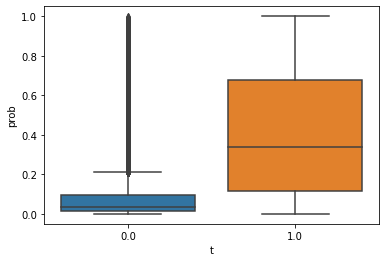

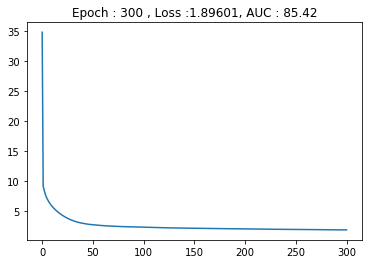

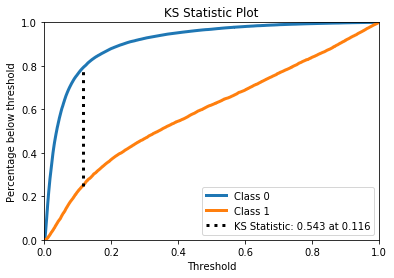

[[26187  6908]
 [ 2380  7183]]


In [ ]:
_Loss_ = []
Epoch= 10000
mb_size = 1000
import scikitplot as skplt
print("Train")
config=tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True
sess = tf.Session(config = config)
sess.run(tf.global_variables_initializer())
for epoch in trange(Epoch , desc = "Loop" ) :
    idx = np.random.permutation(len(train_X))
    XX = train_X.iloc[idx , : ].values
    YY = train_Y[idx]
    batch_iter = int(len(XX) / mb_size)
    _Loss2_ = []
    for idx in range(batch_iter) :
        X_mb = XX[idx*mb_size:(idx+1)*mb_size]
        Y_mb = YY[idx*mb_size:(idx+1)*mb_size]
        Feed = {X : X_mb ,
                y : Y_mb , 
                batch_size : mb_size , }
        _ , LOSS  = sess.run([solver , Loss] , feed_dict= Feed)
        _Loss2_.append(LOSS)
    _Loss_.append(np.mean(_Loss2_))
    if (epoch > 0)  & (epoch % 5 == 0) :
        Feed = { X : test_X.values , batch_size : len(test_X.values) }
        probs  = sess.run(Probs , feed_dict= Feed)
        AUC = roc_auc_score(test_Y ,  probs[:,1])
        DD = pd.DataFrame([test_Y ,probs[:,1]],
                          index = ["t","prob"]).T
        clear_output()
        print( confusion_matrix(test_Y , np.argmax(probs,axis =1) ))
        msg = "Epoch : {} , Loss :{:.5f}, AUC : {:.2f}".format(epoch ,LOSS ,AUC*100)
        sns.boxplot(x="t", y="prob", data=DD)
        plt.show()
        plt.plot(np.arange(len(_Loss_)), _Loss_ )
        plt.title(msg)
        plt.show()        
        pp = skplt.metrics.plot_ks_statistic(test_Y, probs)
        plt.show()
        b , c = pp.get_legend_handles_labels()
        threshold = float(c[2].split("at ")[1])
        aaa = np.where( probs[:,1] < threshold , 0 , 1 )
        print( confusion_matrix(test_Y , aaa ))

In [60]:
a.yaxis.get_major_ticks()[1].get_label()

''